Author: Adrian Gonzalez
    
January 13, 2021

Tested in Python 3.8

# Goal of this notebook

The goal of this notebook is to determine which algorithm produces the best forecast for the variable Over (1=Overindebted, 0 = "Not Overindebted") as defined in the "Logit I" model published on my Ph.D. Dissertation, page 150.

In order to to so, I used "GridSearchCV" to test different parameters combinations for four classification algorithms and find the best one. The data was standardize using "StandardScaler" and "train_test_split" was used to split the data before running GridSearchCV. 

The classification algorithms evaluated in this notebooks are: 

1) logistic,

2) decision tree, 

3) support vector machine (svm) and 

4) K nearest neighbors (knn).
 
The parameters sets used to evaluate the different algorithms have been already refined after running the notebook a few times. They still could be refined more, however, doing so will have only a small effect on the scores of the models.

RESULTS:
The score of the different algorithms evaluated are in the 83-86 range, so they have very similar performance.
The analysis of the confusion matrices confirm this pattern. In particular, based on the confusion matrices, all models fail by overpredicting significantly the number of Overindebted households and underpredicting the number of Not-Overindebted.

NEXT STEPS:
In a new notebook, I will try to improve the forescasting ability of the algorithms by going beyond the models used in the dissertation and adding new explanatory variables.

## Import Libraries and Define Auxiliary Functions


In [1]:
# Pandas for data manipulation and analysis.
import pandas as pd
# NumPy is a library adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework.
import matplotlib.pyplot as plt
# Seaborn is a data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# train_test_split Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# GridSearchCV allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

#for plotting decision trees
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
%matplotlib inline 

#for comparison of logistic coefficients between sklearn and statsmodels
import statsmodels.api as sm
import statsmodels.tools

This function is to plot the confusion matrix.


In [2]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    cm=sns.heatmap(cm, annot=True, ax = ax, fmt="d"); #annot=True to annotate cells, fmt='d' , 
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Not Over', 'Overindebted']); ax.yaxis.set_ticklabels(['Not Over', 'Overindebted'])
    figure = cm.get_figure()    
    return figure

# Reading data¶

In [3]:
#data is availabe in CSV and pickle formats:
#data = pd.read_csv("data_reduced_from_wrangling.csv")
data = pd.read_pickle("data_reduced_from_wrangling.pkl")

In [4]:
data.shape

(1282, 42)

In [5]:
data.head()

,Lazy,Over,six,Cochabamba,El_Alto,La_Paz,Oruro,Santa_Cruz,Shocks,Manufacture,...,Female_Main_Person,Commercial,Assets,cruzados,Shocks_97,Shocks_98,Shocks_99,Shocks_00,Shocks_01,cuest
0,0.0,1.0,B,0,0,1,0,0,1,0,...,0,0,1.139501,0,0,0,0,0,1,2
1,0.0,1.0,B,0,0,1,0,0,1,0,...,1,0,0.080764,0,1,1,0,0,0,3
2,0.0,1.0,C,0,0,1,0,0,1,0,...,1,0,0.080764,1,1,1,1,1,0,3
3,0.0,1.0,C,0,0,1,0,0,1,0,...,0,0,1.294317,0,0,0,0,1,0,4
4,NaN,0.0,A,0,0,1,0,0,1,0,...,1,0,0.409985,0,0,0,1,0,0,5


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1282 entries, 0 to 1281
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Lazy                      1062 non-null   float64
 1   Over                      1256 non-null   float64
 2   six                       1282 non-null   object 
 3   Cochabamba                1282 non-null   int8   
 4   El_Alto                   1282 non-null   int8   
 5   La_Paz                    1282 non-null   int8   
 6   Oruro                     1282 non-null   int8   
 7   Santa_Cruz                1282 non-null   int8   
 8   Shocks                    1282 non-null   int8   
 9   Manufacture               1282 non-null   int8   
 10  Commerce                  1282 non-null   int8   
 11  Services                  1282 non-null   int8   
 12  Individual                1282 non-null   int8   
 13  Consumption               1282 non-null   int8   
 14  Groups  

In [7]:
data.describe()

,Lazy,Over,Cochabamba,El_Alto,La_Paz,Oruro,Santa_Cruz,Shocks,Manufacture,Commerce,...,Female_Main_Person,Commercial,Assets,cruzados,Shocks_97,Shocks_98,Shocks_99,Shocks_00,Shocks_01,cuest
count,1062.000000,1256.000000,1282.000000,1282.000000,1282.000000,1282.000000,1282.000000,1282.000000,1282.000000,1282.000000,...,1282.000000,1282.000000,1282.000000,1282.000000,1282.000000,1282.000000,1282.000000,1282.000000,1282.000000,1282.000000
mean,0.214689,0.845541,0.175507,0.290172,0.175507,0.060842,0.297972,0.686427,0.108424,0.199688,...,0.304992,0.233229,1.743612,0.047582,0.047582,0.092044,0.194228,0.347894,0.411856,479.743370
std,0.410800,0.361532,0.380549,0.454019,0.380549,0.239134,0.457546,0.464126,0.311037,0.399922,...,0.460584,0.423052,3.212543,0.212963,0.212963,0.289200,0.395759,0.476488,0.492361,282.413639
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.168869,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,236.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.626175,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,480.000000
75%,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,1.894200,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,720.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,38.416843,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1293.000000


In [8]:
data.isna().sum()

Lazy                        220
Over                         26
six                           0
Cochabamba                    0
El_Alto                       0
La_Paz                        0
Oruro                         0
Santa_Cruz                    0
Shocks                        0
Manufacture                   0
Commerce                      0
Services                      0
Individual                    0
Consumption                   0
Groups                        0
Village                       0
Others                        0
Loan_Term                    10
Lenders                       0
Years_with_new_loans          0
First_timer                   0
Cohort_1997                   0
Cohort_1998                   0
Cohort_1999                   0
Cohort_2000                   0
Default_First                 0
Number_Potential_Workers      0
Age_Main_Income_Source        3
Education_Average            11
Diversification               0
Savings                       0
Migrants

# DEFINING X VARIABLES

In [9]:
xs1=['Cochabamba', 'El_Alto', 'La_Paz', 'Oruro',
        'Shocks',
        'Manufacture', 'Commerce', 'Services',
        'Individual', 'Groups',  'Village', 'Others',
        'Loan_Term', 'Lenders','Years_with_new_loans',
        'Cohort_1997', 'Cohort_1998', 'Cohort_1999', 'Cohort_2000',
        'Commercial',
        'Age_Main_Income_Source', 'Education_Average']

In [10]:
vars1=['Over']+xs1+['cuest']

In [11]:
data1=data[vars1]
data1.shape

(1282, 24)

In [12]:
data1.isna().sum() #In this notebook I will drop missing rows following the dissertation methodology

Over                      26
Cochabamba                 0
El_Alto                    0
La_Paz                     0
Oruro                      0
Shocks                     0
Manufacture                0
Commerce                   0
Services                   0
Individual                 0
Groups                     0
Village                    0
Others                     0
Loan_Term                 10
Lenders                    0
Years_with_new_loans       0
Cohort_1997                0
Cohort_1998                0
Cohort_1999                0
Cohort_2000                0
Commercial                 0
Age_Main_Income_Source     3
Education_Average         11
cuest                      0
dtype: int64

In [13]:
data1.dropna(axis=0, inplace=True)
data1.shape

C:\Users\adria\anaconda3\envs\Python38forstatsmodels\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


(1236, 24)

In [14]:
X1=data1[xs1]
X1=statsmodels.tools.tools.add_constant(X1, prepend=False) #False, set constant to last column, True first column
Y1=data1['Over']
Y1.value_counts(dropna=False)

1.0    1048
0.0     188
Name: Over, dtype: int64

# Results are the same between "statsmodel' and "sklearn" and identical to "Logit I - Version 1" from "1 Wrangling and Logits"

In [15]:
model1 = sm.Logit(Y1,X1)
result1 = model1.fit(full_output=True, disp=True, tol=0.0000000001)
result1.summary()

Optimization terminated successfully.
         Current function value: 0.390905
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Over   No. Observations:                 1236
Model:                          Logit   Df Residuals:                     1213
Method:                           MLE   Df Model:                           22
Date:                Thu, 13 Jan 2022   Pseudo R-squ.:                 0.08312
Time:                        11:24:24   Log-Likelihood:                -483.16
converged:                       True   LL-Null:                       -526.96
Covariance Type:            nonrobust   LLR p-value:                 8.758e-10
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Cochabamba                 0.3152      0.252      1.252      0.211      -0.178       0.809
El_Alto                    0.4535      0.244      1.862      0.063      -0.024       0.931
La_Paz                     0.7075      0.299      2.363      0.018       0.121       1.294
Oruro                      0.8817      0.407      2.164      0.030       0.083       1.680
Shocks                     0.8040      0.192      4.177      0.000       0.427       1.181
Manufacture               -0.4750      0.301     -1.579      0.114      -1.065       0.115
Commerce                   0.0543      0.270      0.201      0.841      -0.475       0.583
Services                  -0.0396      0.218     -0.181      0.856      -0.468       0.389
Individual                 0.1402      0.303      0.463      0.643      -0.453       0.733
Groups                     0.1404      0.270      0.520      0.603      -0.389       0.670
Village                   -0.0639      0.343     -0.186      0.852      -0.736       0.608
Others                    -0.2010      0.266     -0.754      0.451      -0.723       0.321
Loan_Term                  0.1106      0.061      1.805      0.071      -0.009       0.231
Lenders                   -0.0085      0.112     -0.076      0.939      -0.227       0.210
Years_with_new_loans      -0.3752      0.104     -3.611      0.000      -0.579      -0.172
Cohort_1997                1.8354      0.326      5.635      0.000       1.197       2.474
Cohort_1998                1.3395      0.285      4.695      0.000       0.780       1.899
Cohort_1999                1.2087      0.281      4.300      0.000       0.658       1.760
Cohort_2000                0.8864      0.274      3.235      0.001       0.349       1.423
Commercial                 0.8275      0.237      3.487      0.000       0.362       1.293
Age_Main_Income_Source    -0.0074      0.008     -0.934      0.350      -0.023       0.008
Education_Average         -0.0514      0.025     -2.053      0.040      -0.101      -0.002
const                      0.8016      0.555      1.443      0.149      -0.287       1.890
==========================================================================================
"""

In [16]:
lr=LogisticRegression(penalty='none', fit_intercept=False, solver='newton-cg', max_iter=500)
lr.fit(X1,Y1)
coefficients = pd.concat([pd.DataFrame(X1.columns),pd.DataFrame(np.transpose(lr.coef_))], axis = 1)
coefficients

,0,0
0,Cochabamba,0.315196
1,El_Alto,0.453526
2,La_Paz,0.707453
3,Oruro,0.881657
4,Shocks,0.803977
5,Manufacture,-0.474952
6,Commerce,0.054321
7,Services,-0.039575
8,Individual,0.140216
9,Groups,0.140390


# Standardizing the data in <code>X</code> then reassign it to the variable  <code>XT1</code> using the transform provided below.


In [17]:
# TRANSFORMER
transformer = preprocessing.StandardScaler()
transformer.fit(X1)

StandardScaler()

In [18]:
XT1=transformer.transform(X1, copy=True)
XT1

array([[-0.46017899, -0.64231723,  2.17306747, ...,  1.65042414,
        -1.735406  ,  0.        ],
       [-0.46017899, -0.64231723,  2.17306747, ...,  0.48536342,
         0.4708387 ,  0.        ],
       [-0.46017899, -0.64231723,  2.17306747, ...,  0.48536342,
         0.4708387 ,  0.        ],
       ...,
       [ 2.17306747, -0.64231723, -0.46017899, ...,  0.19409824,
         0.11499278,  0.        ],
       [ 2.17306747, -0.64231723, -0.46017899, ...,  0.19409824,
         0.11499278,  0.        ],
       [-0.46017899, -0.64231723, -0.46017899, ...,  0.48536342,
        -0.31202232,  0.        ]])

# Training and Testing Data

In a typycal datascience forescasting analysis, it is common practice to split the data into training and testing data using the  function  <code>train_test_split</code>.   By doing this, the training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.

In this notebook I will follow this practice, even thought this will render the results not directly comparable with those published in the dissertation.

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(XT1, Y1, test_size=0.2, random_state=42)

In [20]:
Y_test.shape

(248,)

## Logistic regression


Creates a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [21]:
parameters ={"C":[0.0001, 0.001, 0.01,0.1],'penalty':['l2'], 'solver':['newton-cg', 'lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters, refit=True, cv=10, verbose=3, error_score='raise')
logreg_cv.fit(X_train, Y_train)


Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV 1/10] END C=0.0001, penalty=l2, solver=newton-cg;, score=0.848 total time=   0.0s
[CV 2/10] END C=0.0001, penalty=l2, solver=newton-cg;, score=0.848 total time=   0.0s
[CV 3/10] END C=0.0001, penalty=l2, solver=newton-cg;, score=0.848 total time=   0.0s
[CV 4/10] END C=0.0001, penalty=l2, solver=newton-cg;, score=0.848 total time=   0.0s
[CV 5/10] END C=0.0001, penalty=l2, solver=newton-cg;, score=0.848 total time=   0.0s
[CV 6/10] END C=0.0001, penalty=l2, solver=newton-cg;, score=0.848 total time=   0.0s
[CV 7/10] END C=0.0001, penalty=l2, solver=newton-cg;, score=0.848 total time=   0.0s
[CV 8/10] END C=0.0001, penalty=l2, solver=newton-cg;, score=0.838 total time=   0.0s
[CV 9/10] END C=0.0001, penalty=l2, solver=newton-cg;, score=0.847 total time=   0.0s
[CV 10/10] END C=0.0001, penalty=l2, solver=newton-cg;, score=0.847 total time=   0.0s
[CV 1/10] END C=0.0001, penalty=l2, solver=lbfgs;, score=0.848 total time=   0

GridSearchCV(cv=10, error_score='raise', estimator=LogisticRegression(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs']},
             verbose=3)

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [22]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.0001, 'penalty': 'l2', 'solver': 'newton-cg'}
accuracy : 0.8471655328798187


## Score for logistic regression


In [23]:
log_score=logreg_cv.score(X_test, Y_test)
log_score

0.8508064516129032

Lets look at the confusion matrix:


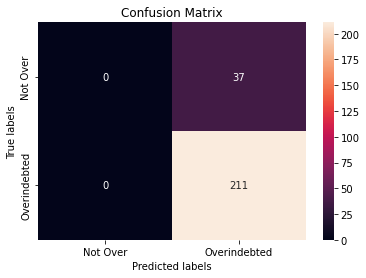

In [24]:
yhat_log=logreg_cv.predict(X_test)
cm_log=plot_confusion_matrix(Y_test,yhat_log)

211 cases are classified correctly.  The major problem is the 37 false Overindebtedness and 0 true negatives.

## Support Vector Machine (SVM)


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [25]:
#This notebook takes many hours to run when 'linear' is included in the parameters of GridSearchCV.
#if you want to run this faster, remove 'linear' from the following line.
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-0, 1, 5),
              'gamma':np.logspace(-0, 1, 5)}

svm = SVC()

In [26]:
svm_cv = GridSearchCV(svm, parameters, refit=True, cv=10, verbose=3)
svm_cv.fit(X_train, Y_train)

Fitting 10 folds for each of 125 candidates, totalling 1250 fits
[CV 1/10] END ..C=1.0, gamma=1.0, kernel=linear;, score=0.848 total time=   0.0s
[CV 2/10] END ..C=1.0, gamma=1.0, kernel=linear;, score=0.848 total time=   0.0s
[CV 3/10] END ..C=1.0, gamma=1.0, kernel=linear;, score=0.848 total time=   0.0s
[CV 4/10] END ..C=1.0, gamma=1.0, kernel=linear;, score=0.848 total time=   0.0s
[CV 5/10] END ..C=1.0, gamma=1.0, kernel=linear;, score=0.848 total time=   0.0s
[CV 6/10] END ..C=1.0, gamma=1.0, kernel=linear;, score=0.848 total time=   0.0s
[CV 7/10] END ..C=1.0, gamma=1.0, kernel=linear;, score=0.848 total time=   0.0s
[CV 8/10] END ..C=1.0, gamma=1.0, kernel=linear;, score=0.838 total time=   0.0s
[CV 9/10] END ..C=1.0, gamma=1.0, kernel=linear;, score=0.847 total time=   0.0s
[CV 10/10] END .C=1.0, gamma=1.0, kernel=linear;, score=0.847 total time=   0.0s
[CV 1/10] END .....C=1.0, gamma=1.0, kernel=rbf;, score=0.848 total time=   0.0s
[CV 2/10] END .....C=1.0, gamma=1.0, kernel=

[CV 6/10] END C=1.0, gamma=1.7782794100389228, kernel=sigmoid;, score=0.808 total time=   0.0s
[CV 7/10] END C=1.0, gamma=1.7782794100389228, kernel=sigmoid;, score=0.788 total time=   0.0s
[CV 8/10] END C=1.0, gamma=1.7782794100389228, kernel=sigmoid;, score=0.758 total time=   0.0s
[CV 9/10] END C=1.0, gamma=1.7782794100389228, kernel=sigmoid;, score=0.755 total time=   0.0s
[CV 10/10] END C=1.0, gamma=1.7782794100389228, kernel=sigmoid;, score=0.765 total time=   0.0s
[CV 1/10] END C=1.0, gamma=3.1622776601683795, kernel=linear;, score=0.848 total time=   0.0s
[CV 2/10] END C=1.0, gamma=3.1622776601683795, kernel=linear;, score=0.848 total time=   0.0s
[CV 3/10] END C=1.0, gamma=3.1622776601683795, kernel=linear;, score=0.848 total time=   0.0s
[CV 4/10] END C=1.0, gamma=3.1622776601683795, kernel=linear;, score=0.848 total time=   0.0s
[CV 5/10] END C=1.0, gamma=3.1622776601683795, kernel=linear;, score=0.848 total time=   0.0s
[CV 6/10] END C=1.0, gamma=3.1622776601683795, kernel=

[CV 8/10] END C=1.0, gamma=5.623413251903491, kernel=rbf;, score=0.838 total time=   0.0s
[CV 9/10] END C=1.0, gamma=5.623413251903491, kernel=rbf;, score=0.847 total time=   0.0s
[CV 10/10] END C=1.0, gamma=5.623413251903491, kernel=rbf;, score=0.847 total time=   0.0s
[CV 1/10] END C=1.0, gamma=5.623413251903491, kernel=sigmoid;, score=0.727 total time=   0.0s
[CV 2/10] END C=1.0, gamma=5.623413251903491, kernel=sigmoid;, score=0.747 total time=   0.0s
[CV 3/10] END C=1.0, gamma=5.623413251903491, kernel=sigmoid;, score=0.778 total time=   0.0s
[CV 4/10] END C=1.0, gamma=5.623413251903491, kernel=sigmoid;, score=0.788 total time=   0.0s
[CV 5/10] END C=1.0, gamma=5.623413251903491, kernel=sigmoid;, score=0.758 total time=   0.0s
[CV 6/10] END C=1.0, gamma=5.623413251903491, kernel=sigmoid;, score=0.758 total time=   0.0s
[CV 7/10] END C=1.0, gamma=5.623413251903491, kernel=sigmoid;, score=0.828 total time=   0.0s
[CV 8/10] END C=1.0, gamma=5.623413251903491, kernel=sigmoid;, score=0.

[CV 5/10] END C=1.7782794100389228, gamma=1.0, kernel=rbf;, score=0.838 total time=   0.0s
[CV 6/10] END C=1.7782794100389228, gamma=1.0, kernel=rbf;, score=0.828 total time=   0.0s
[CV 7/10] END C=1.7782794100389228, gamma=1.0, kernel=rbf;, score=0.848 total time=   0.0s
[CV 8/10] END C=1.7782794100389228, gamma=1.0, kernel=rbf;, score=0.848 total time=   0.0s
[CV 9/10] END C=1.7782794100389228, gamma=1.0, kernel=rbf;, score=0.837 total time=   0.0s
[CV 10/10] END C=1.7782794100389228, gamma=1.0, kernel=rbf;, score=0.847 total time=   0.0s
[CV 1/10] END C=1.7782794100389228, gamma=1.0, kernel=sigmoid;, score=0.788 total time=   0.0s
[CV 2/10] END C=1.7782794100389228, gamma=1.0, kernel=sigmoid;, score=0.798 total time=   0.0s
[CV 3/10] END C=1.7782794100389228, gamma=1.0, kernel=sigmoid;, score=0.818 total time=   0.0s
[CV 4/10] END C=1.7782794100389228, gamma=1.0, kernel=sigmoid;, score=0.768 total time=   0.0s
[CV 5/10] END C=1.7782794100389228, gamma=1.0, kernel=sigmoid;, score=0.7

[CV 6/10] END C=1.7782794100389228, gamma=3.1622776601683795, kernel=rbf;, score=0.848 total time=   0.0s
[CV 7/10] END C=1.7782794100389228, gamma=3.1622776601683795, kernel=rbf;, score=0.859 total time=   0.0s
[CV 8/10] END C=1.7782794100389228, gamma=3.1622776601683795, kernel=rbf;, score=0.848 total time=   0.0s
[CV 9/10] END C=1.7782794100389228, gamma=3.1622776601683795, kernel=rbf;, score=0.847 total time=   0.0s
[CV 10/10] END C=1.7782794100389228, gamma=3.1622776601683795, kernel=rbf;, score=0.847 total time=   0.0s
[CV 1/10] END C=1.7782794100389228, gamma=3.1622776601683795, kernel=poly;, score=0.717 total time=   0.0s
[CV 2/10] END C=1.7782794100389228, gamma=3.1622776601683795, kernel=poly;, score=0.697 total time=   0.0s
[CV 3/10] END C=1.7782794100389228, gamma=3.1622776601683795, kernel=poly;, score=0.727 total time=   0.0s
[CV 4/10] END C=1.7782794100389228, gamma=3.1622776601683795, kernel=poly;, score=0.636 total time=   0.0s
[CV 5/10] END C=1.7782794100389228, gamma

[CV 10/10] END C=1.7782794100389228, gamma=5.623413251903491, kernel=sigmoid;, score=0.776 total time=   0.0s
[CV 1/10] END C=1.7782794100389228, gamma=10.0, kernel=linear;, score=0.848 total time=   0.0s
[CV 2/10] END C=1.7782794100389228, gamma=10.0, kernel=linear;, score=0.848 total time=   0.0s
[CV 3/10] END C=1.7782794100389228, gamma=10.0, kernel=linear;, score=0.848 total time=   0.0s
[CV 4/10] END C=1.7782794100389228, gamma=10.0, kernel=linear;, score=0.848 total time=   0.0s
[CV 5/10] END C=1.7782794100389228, gamma=10.0, kernel=linear;, score=0.848 total time=   0.0s
[CV 6/10] END C=1.7782794100389228, gamma=10.0, kernel=linear;, score=0.848 total time=   0.0s
[CV 7/10] END C=1.7782794100389228, gamma=10.0, kernel=linear;, score=0.848 total time=   0.0s
[CV 8/10] END C=1.7782794100389228, gamma=10.0, kernel=linear;, score=0.838 total time=   0.0s
[CV 9/10] END C=1.7782794100389228, gamma=10.0, kernel=linear;, score=0.847 total time=   0.0s
[CV 10/10] END C=1.7782794100389228

[CV 10/10] END C=3.1622776601683795, gamma=1.0, kernel=rbf;, score=0.847 total time=   0.0s
[CV 1/10] END C=3.1622776601683795, gamma=1.0, kernel=sigmoid;, score=0.768 total time=   0.0s
[CV 2/10] END C=3.1622776601683795, gamma=1.0, kernel=sigmoid;, score=0.788 total time=   0.0s
[CV 3/10] END C=3.1622776601683795, gamma=1.0, kernel=sigmoid;, score=0.808 total time=   0.0s
[CV 4/10] END C=3.1622776601683795, gamma=1.0, kernel=sigmoid;, score=0.788 total time=   0.0s
[CV 5/10] END C=3.1622776601683795, gamma=1.0, kernel=sigmoid;, score=0.758 total time=   0.0s
[CV 6/10] END C=3.1622776601683795, gamma=1.0, kernel=sigmoid;, score=0.727 total time=   0.0s
[CV 7/10] END C=3.1622776601683795, gamma=1.0, kernel=sigmoid;, score=0.768 total time=   0.0s
[CV 8/10] END C=3.1622776601683795, gamma=1.0, kernel=sigmoid;, score=0.788 total time=   0.0s
[CV 9/10] END C=3.1622776601683795, gamma=1.0, kernel=sigmoid;, score=0.765 total time=   0.0s
[CV 10/10] END C=3.1622776601683795, gamma=1.0, kerne

[CV 8/10] END C=3.1622776601683795, gamma=3.1622776601683795, kernel=rbf;, score=0.848 total time=   0.0s
[CV 9/10] END C=3.1622776601683795, gamma=3.1622776601683795, kernel=rbf;, score=0.847 total time=   0.0s
[CV 10/10] END C=3.1622776601683795, gamma=3.1622776601683795, kernel=rbf;, score=0.847 total time=   0.0s
[CV 1/10] END C=3.1622776601683795, gamma=3.1622776601683795, kernel=poly;, score=0.717 total time=   0.0s
[CV 2/10] END C=3.1622776601683795, gamma=3.1622776601683795, kernel=poly;, score=0.697 total time=   0.0s
[CV 3/10] END C=3.1622776601683795, gamma=3.1622776601683795, kernel=poly;, score=0.727 total time=   0.0s
[CV 4/10] END C=3.1622776601683795, gamma=3.1622776601683795, kernel=poly;, score=0.636 total time=   0.0s
[CV 5/10] END C=3.1622776601683795, gamma=3.1622776601683795, kernel=poly;, score=0.667 total time=   0.0s
[CV 6/10] END C=3.1622776601683795, gamma=3.1622776601683795, kernel=poly;, score=0.737 total time=   0.0s
[CV 7/10] END C=3.1622776601683795, gam

[CV 7/10] END C=3.1622776601683795, gamma=5.623413251903491, kernel=sigmoid;, score=0.838 total time=   0.0s
[CV 8/10] END C=3.1622776601683795, gamma=5.623413251903491, kernel=sigmoid;, score=0.758 total time=   0.0s
[CV 9/10] END C=3.1622776601683795, gamma=5.623413251903491, kernel=sigmoid;, score=0.786 total time=   0.0s
[CV 10/10] END C=3.1622776601683795, gamma=5.623413251903491, kernel=sigmoid;, score=0.755 total time=   0.0s
[CV 1/10] END C=3.1622776601683795, gamma=10.0, kernel=linear;, score=0.848 total time=   0.0s
[CV 2/10] END C=3.1622776601683795, gamma=10.0, kernel=linear;, score=0.848 total time=   0.0s
[CV 3/10] END C=3.1622776601683795, gamma=10.0, kernel=linear;, score=0.848 total time=   0.0s
[CV 4/10] END C=3.1622776601683795, gamma=10.0, kernel=linear;, score=0.848 total time=   0.0s
[CV 5/10] END C=3.1622776601683795, gamma=10.0, kernel=linear;, score=0.848 total time=   0.0s
[CV 6/10] END C=3.1622776601683795, gamma=10.0, kernel=linear;, score=0.848 total time= 

[CV 5/10] END C=5.623413251903491, gamma=1.0, kernel=rbf;, score=0.838 total time=   0.0s
[CV 6/10] END C=5.623413251903491, gamma=1.0, kernel=rbf;, score=0.828 total time=   0.0s
[CV 7/10] END C=5.623413251903491, gamma=1.0, kernel=rbf;, score=0.848 total time=   0.0s
[CV 8/10] END C=5.623413251903491, gamma=1.0, kernel=rbf;, score=0.859 total time=   0.0s
[CV 9/10] END C=5.623413251903491, gamma=1.0, kernel=rbf;, score=0.837 total time=   0.0s
[CV 10/10] END C=5.623413251903491, gamma=1.0, kernel=rbf;, score=0.847 total time=   0.0s
[CV 1/10] END C=5.623413251903491, gamma=1.0, kernel=sigmoid;, score=0.798 total time=   0.0s
[CV 2/10] END C=5.623413251903491, gamma=1.0, kernel=sigmoid;, score=0.778 total time=   0.0s
[CV 3/10] END C=5.623413251903491, gamma=1.0, kernel=sigmoid;, score=0.808 total time=   0.0s
[CV 4/10] END C=5.623413251903491, gamma=1.0, kernel=sigmoid;, score=0.808 total time=   0.0s
[CV 5/10] END C=5.623413251903491, gamma=1.0, kernel=sigmoid;, score=0.747 total ti

[CV 7/10] END C=5.623413251903491, gamma=3.1622776601683795, kernel=rbf;, score=0.859 total time=   0.0s
[CV 8/10] END C=5.623413251903491, gamma=3.1622776601683795, kernel=rbf;, score=0.848 total time=   0.0s
[CV 9/10] END C=5.623413251903491, gamma=3.1622776601683795, kernel=rbf;, score=0.847 total time=   0.0s
[CV 10/10] END C=5.623413251903491, gamma=3.1622776601683795, kernel=rbf;, score=0.847 total time=   0.0s
[CV 1/10] END C=5.623413251903491, gamma=3.1622776601683795, kernel=poly;, score=0.717 total time=   0.0s
[CV 2/10] END C=5.623413251903491, gamma=3.1622776601683795, kernel=poly;, score=0.697 total time=   0.0s
[CV 3/10] END C=5.623413251903491, gamma=3.1622776601683795, kernel=poly;, score=0.727 total time=   0.0s
[CV 4/10] END C=5.623413251903491, gamma=3.1622776601683795, kernel=poly;, score=0.636 total time=   0.0s
[CV 5/10] END C=5.623413251903491, gamma=3.1622776601683795, kernel=poly;, score=0.667 total time=   0.0s
[CV 6/10] END C=5.623413251903491, gamma=3.162277

[CV 10/10] END C=5.623413251903491, gamma=5.623413251903491, kernel=sigmoid;, score=0.776 total time=   0.0s
[CV 1/10] END C=5.623413251903491, gamma=10.0, kernel=linear;, score=0.848 total time=   0.0s
[CV 2/10] END C=5.623413251903491, gamma=10.0, kernel=linear;, score=0.848 total time=   0.0s
[CV 3/10] END C=5.623413251903491, gamma=10.0, kernel=linear;, score=0.848 total time=   0.0s
[CV 4/10] END C=5.623413251903491, gamma=10.0, kernel=linear;, score=0.848 total time=   0.0s
[CV 5/10] END C=5.623413251903491, gamma=10.0, kernel=linear;, score=0.848 total time=   0.0s
[CV 6/10] END C=5.623413251903491, gamma=10.0, kernel=linear;, score=0.848 total time=   0.0s
[CV 7/10] END C=5.623413251903491, gamma=10.0, kernel=linear;, score=0.848 total time=   0.0s
[CV 8/10] END C=5.623413251903491, gamma=10.0, kernel=linear;, score=0.838 total time=   0.0s
[CV 9/10] END C=5.623413251903491, gamma=10.0, kernel=linear;, score=0.847 total time=   0.0s
[CV 10/10] END C=5.623413251903491, gamma=10.

[CV 4/10] END C=10.0, gamma=1.0, kernel=sigmoid;, score=0.798 total time=   0.0s
[CV 5/10] END C=10.0, gamma=1.0, kernel=sigmoid;, score=0.758 total time=   0.0s
[CV 6/10] END C=10.0, gamma=1.0, kernel=sigmoid;, score=0.798 total time=   0.0s
[CV 7/10] END C=10.0, gamma=1.0, kernel=sigmoid;, score=0.737 total time=   0.0s
[CV 8/10] END C=10.0, gamma=1.0, kernel=sigmoid;, score=0.828 total time=   0.0s
[CV 9/10] END C=10.0, gamma=1.0, kernel=sigmoid;, score=0.786 total time=   0.0s
[CV 10/10] END C=10.0, gamma=1.0, kernel=sigmoid;, score=0.745 total time=   0.0s
[CV 1/10] END C=10.0, gamma=1.7782794100389228, kernel=linear;, score=0.848 total time=   0.0s
[CV 2/10] END C=10.0, gamma=1.7782794100389228, kernel=linear;, score=0.848 total time=   0.0s
[CV 3/10] END C=10.0, gamma=1.7782794100389228, kernel=linear;, score=0.848 total time=   0.0s
[CV 4/10] END C=10.0, gamma=1.7782794100389228, kernel=linear;, score=0.848 total time=   0.0s
[CV 5/10] END C=10.0, gamma=1.7782794100389228, kern

[CV 5/10] END C=10.0, gamma=3.1622776601683795, kernel=rbf;, score=0.859 total time=   0.0s
[CV 6/10] END C=10.0, gamma=3.1622776601683795, kernel=rbf;, score=0.848 total time=   0.0s
[CV 7/10] END C=10.0, gamma=3.1622776601683795, kernel=rbf;, score=0.859 total time=   0.0s
[CV 8/10] END C=10.0, gamma=3.1622776601683795, kernel=rbf;, score=0.848 total time=   0.0s
[CV 9/10] END C=10.0, gamma=3.1622776601683795, kernel=rbf;, score=0.847 total time=   0.0s
[CV 10/10] END C=10.0, gamma=3.1622776601683795, kernel=rbf;, score=0.847 total time=   0.0s
[CV 1/10] END C=10.0, gamma=3.1622776601683795, kernel=sigmoid;, score=0.717 total time=   0.0s
[CV 2/10] END C=10.0, gamma=3.1622776601683795, kernel=sigmoid;, score=0.758 total time=   0.0s
[CV 3/10] END C=10.0, gamma=3.1622776601683795, kernel=sigmoid;, score=0.798 total time=   0.0s
[CV 4/10] END C=10.0, gamma=3.1622776601683795, kernel=sigmoid;, score=0.808 total time=   0.0s
[CV 5/10] END C=10.0, gamma=3.1622776601683795, kernel=sigmoid;

[CV 8/10] END ..C=10.0, gamma=10.0, kernel=poly;, score=0.717 total time=   0.0s
[CV 9/10] END ..C=10.0, gamma=10.0, kernel=poly;, score=0.735 total time=   0.0s
[CV 10/10] END .C=10.0, gamma=10.0, kernel=poly;, score=0.765 total time=   0.0s
[CV 1/10] END ...C=10.0, gamma=10.0, kernel=rbf;, score=0.848 total time=   0.0s
[CV 2/10] END ...C=10.0, gamma=10.0, kernel=rbf;, score=0.848 total time=   0.0s
[CV 3/10] END ...C=10.0, gamma=10.0, kernel=rbf;, score=0.848 total time=   0.0s
[CV 4/10] END ...C=10.0, gamma=10.0, kernel=rbf;, score=0.848 total time=   0.0s
[CV 5/10] END ...C=10.0, gamma=10.0, kernel=rbf;, score=0.848 total time=   0.0s
[CV 6/10] END ...C=10.0, gamma=10.0, kernel=rbf;, score=0.848 total time=   0.0s
[CV 7/10] END ...C=10.0, gamma=10.0, kernel=rbf;, score=0.848 total time=   0.0s
[CV 8/10] END ...C=10.0, gamma=10.0, kernel=rbf;, score=0.838 total time=   0.0s
[CV 9/10] END ...C=10.0, gamma=10.0, kernel=rbf;, score=0.847 total time=   0.0s
[CV 10/10] END ..C=10.0, gam

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([ 1.        ,  1.77827941,  3.16227766,  5.62341325, 10.        ]),
                         'gamma': array([ 1.        ,  1.77827941,  3.16227766,  5.62341325, 10.        ]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')},
             verbose=3)

In [27]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 3.1622776601683795, 'gamma': 3.1622776601683795, 'kernel': 'rbf'}
accuracy : 0.8491857349000206


## Score for SVM


In [28]:
svm_score=svm_cv.score(X_test, Y_test)
svm_score

0.8467741935483871

Plottion the confusion matrix


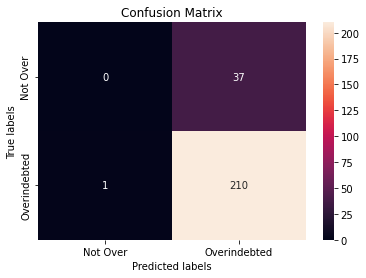

In [29]:
yhat_svm=svm_cv.predict(X_test)
cm_svm=plot_confusion_matrix(Y_test,yhat_svm)

## Decision tree


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [30]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}
dtree = DecisionTreeClassifier()

In [31]:
tree_cv = GridSearchCV(dtree, parameters, refit=True, cv=10, verbose=1)
tree_cv.fit(X_train, Y_train)

Fitting 10 folds for each of 648 candidates, totalling 6480 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             verbose=1)

In [32]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'best'}
accuracy : 0.8491960420531848


## Score for Decision tree


In [33]:
tree_score=tree_cv.score(X_test, Y_test)
tree_score

0.8467741935483871

Plotting the confusion matrix


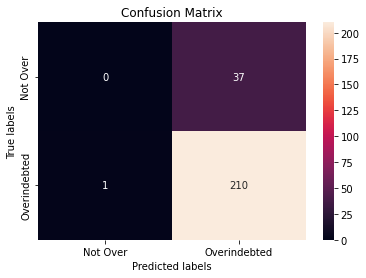

In [34]:
yhat_tree = tree_cv.predict(X_test)
cm_tree=plot_confusion_matrix(Y_test,yhat_tree)

# Draw Best Decision Tree from GridSearchCV

In [35]:
class_names= np.unique(Y_train)
class_names

array([0., 1.])

In [36]:
dot_data = StringIO()
filename = "overtree.png"
featureNames = X1.columns
out=tree.export_graphviz(tree_cv.best_estimator_, feature_names=featureNames, out_file=dot_data, class_names= ('Not Over', 'Overindebted'),  filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(200, 400))
plt.imshow(img,interpolation='nearest')

## K nearest neighbors (KNN)

Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [37]:
parameters = {'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}
KNN = KNeighborsClassifier()

In [38]:
knn_cv = GridSearchCV(KNN, parameters, refit=True, cv=10, verbose=1)
knn_cv.fit(X_train, Y_train)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                         'p': [1, 2]},
             verbose=1)

In [39]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 11, 'p': 2}
accuracy : 0.845124716553288


## Score for KNN


In [40]:
knn_score=knn_cv.score(X_test, Y_test)
knn_score

0.8548387096774194

Plotting the confusion matrix


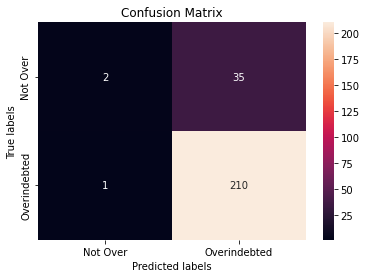

In [41]:
yhat_knn = knn_cv.predict(X_test)
cm_knn=plot_confusion_matrix(Y_test,yhat_knn)

## Comparing the scores of all methods


In [42]:
scores_numpy = np.array([("Logistic Reg.", log_score), ("Dec. Tree", tree_score), ("SVM", svm_score), ("KNN", knn_score)])
scores_numpy

array([['Logistic Reg.', '0.8508064516129032'],
       ['Dec. Tree', '0.8467741935483871'],
       ['SVM', '0.8467741935483871'],
       ['KNN', '0.8548387096774194']], dtype='<U32')

In [43]:
scores = pd.DataFrame(data=scores_numpy, columns=["Model", "Scores"])
scores.dtypes

Model     object
Scores    object
dtype: object

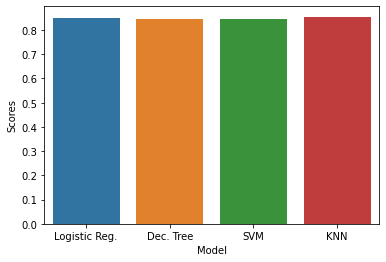

In [44]:
scores["Scores"]=scores["Scores"].astype(float, copy=True, errors='raise')
scores.dtypes
bar = sns.barplot(x="Model", y="Scores", data=scores)

# Comparing the confusion matrices for all methods: 

## Logit

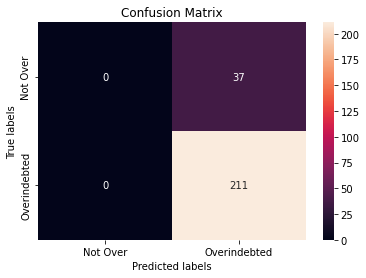

In [45]:
cm_log

# Decision Tree


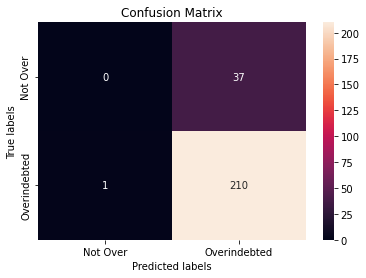

In [46]:
cm_tree

# Support Vector Machine

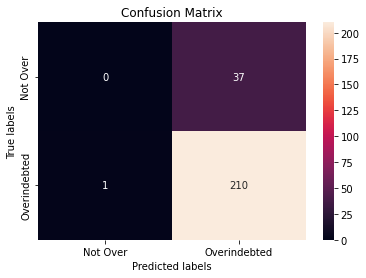

In [47]:
cm_svm

# K-nearest neighbors

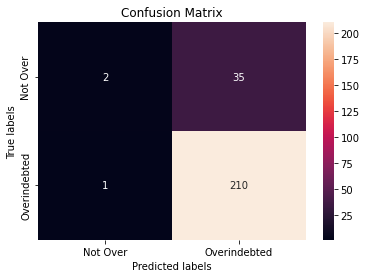

In [48]:
cm_knn

In [49]:
from datetime import datetime
now = datetime.now()
print("Everything ran OK on:", now)

Everything ran OK on: 2022-01-13 11:25:45.774773
